**Author**: Andy Tzanidakis and the LINCC team \
**Last updated:** Aug 29, 2024

## Overview

Learn how to:

- Use VizieR TAP query to access tables and store/handle them in `LSDB`
- Use those catalogs to perform crossmatching with existing `LSDB` catalogs
- Perform time-series analysis and exploration with `nested-dask`

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import astropy.units as u
import dask
from dask.distributed import Client

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hipscat.inspection import plot_pixels
from hipscat.io.file_io import read_parquet_metadata
from cesium import featurize

# ViZier and Aladin querying 
from pyvo import registry  # version >=1.4.1 
from mocpy import MOC
from ipyaladin import Aladin

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

print(f'Version of lsdb is {lsdb.__version__}')

Version of lsdb is 0.3.0


## Initialize Dask Client

Before we start building our workflow, let's initialize our Dask Client. The machine we're using has 8 cores and 25GiB of RAM so we'll decide to make good use of resources and go with 2 workers, each with 12 GiB of memory and 1 thread.

In [2]:
from dask.distributed import Client
client = Client(n_workers=2, memory_limit='12GiB', threads_per_worker=1)

## Get Gaia and ZTF

Let's read Gaia and ZTF (both lazily) as demonstrated in the first two notebooks.

In [3]:
catalogs_dir = "https://data.lsdb.io/unstable/"

# Gaia
gaia_path = f"{catalogs_dir}/gaia_dr3/gaia"

# ZTF
ztf_object_path = f"{catalogs_dir}/ztf/ztf_dr14/"
ztf_source_path = f"{catalogs_dir}/ztf/ztf_zource/"
ztf_object_margin_path = f"{catalogs_dir}/ztf/ztf_dr14_10arcs"

In [4]:
%%time

# Define a cone region of interest
cone_search = ConeSearch(ra=100, dec=27.5, radius_arcsec=4*3600)

gaia = lsdb.read_hipscat(gaia_path, columns=['ra', 'dec', 'parallax'], search_filter=cone_search)

# Load ZTF object table
ztf = lsdb.read_hipscat(
    ztf_object_path, 
    columns=['ra', 'dec', 'ps1_objid'], 
    margin_cache=ztf_object_margin_path, 
    search_filter=cone_search)

# Load ZTF DR14 zources
ztf_sources = lsdb.read_hipscat(
    ztf_source_path, 
    columns=['ra', 'dec', 'mjd', 'mag', 'magerr', 'band', 'ps1_objid', 'catflags'], 
    search_filter=cone_search)

CPU times: user 806 ms, sys: 260 ms, total: 1.07 s
Wall time: 4.33 s


## Query VizieR

We will now access data from VizieR via the [VizieR catalogs](https://cdsarc.u-strasbg.fr/viz-bin/cat/) service. We will be working with the `Gaia DR3 Golden Catalog`, a homogeneous sample of stars with high-quality stellar astrophysical parameters by exploiting data from the Gaia DR3 catalog. 
1. Visit the [VizieR catalogs](https://cdsarc.u-strasbg.fr/viz-bin/cat/) service
2. Search "Gaia DR3"
2. Copy catalog ID number

In [5]:
CATALOGUE = "I/360" # from VizieR

catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"

# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

Let's learn more about the particular catalog we just selected.

In [6]:
voresource.describe(verbose=True)

Gaia DR3 Part 6. Performance verification
Short Name: I/360
IVOA Identifier: ivo://cds.vizier/i/360
Access modes: conesearch, hips#hips-1.0, tap#aux, web
Multi-capability service -- use get_service()

Gaia Data Release 3 (Gaia DR3) will be released on 13 June 2022. The Gaia DR3
catalogue builds upon the Early Data Release 3 (released on 3 December 2020)
and combines, for the same stretch of time and the same set of observations,
these already-published data products with numerous new data products such as
extended objects and non-single stars.

Waveband Coverage: optical

Source: 2022yCat.1360....0G
Authors: Gaia collaboration
Alternative identifier(s): doi:10.26093/cds/vizier.1360
More info: https://cdsarc.cds.unistra.fr/viz-bin/cat/I/360


And then understand which tables are available:

In [7]:
tables = voresource.get_tables()
tables_names = list(tables.keys())
print(f"Available table names: {tables_names}")

Available table names: ['I/360/syntphot', 'I/360/goldu', 'I/360/goldsp', 'I/360/goldsa', 'I/360/goldoba', 'I/360/goldf', 'I/360/goldc', 'I/360/binmass']


For the purpose of this workflow we decided to:
- Pick the `I/360/goldf` table (Golden Catalog).
- Define a `large 40x40 degree` patch of sky, $RA \in [80,120]$ and $DEC \in [0,40]$.
- Request the first `2 million rows`.

The query, written in SQL (Standard Query Language), is sent to the Vizier TAP service.

In [8]:
goldf_table_name = "I/360/goldf"

In [9]:
tap_records = voresource.get_service("tap").run_sync(f'SELECT TOP 2000000  * \
    FROM "{goldf_table_name}" WHERE (DE_ICRS BETWEEN 0 and 40) AND (RA_ICRS BETWEEN 80 and 120)')

Now that we obtained the data from the query, let's convert it to a Pandas DataFrame and plot it.

In [10]:
samples_df = tap_records.to_table().to_pandas()
print (f"Number of objects: {len(samples_df)}")

Number of objects: 146151


Text(0, 0.5, 'DEC [deg]')

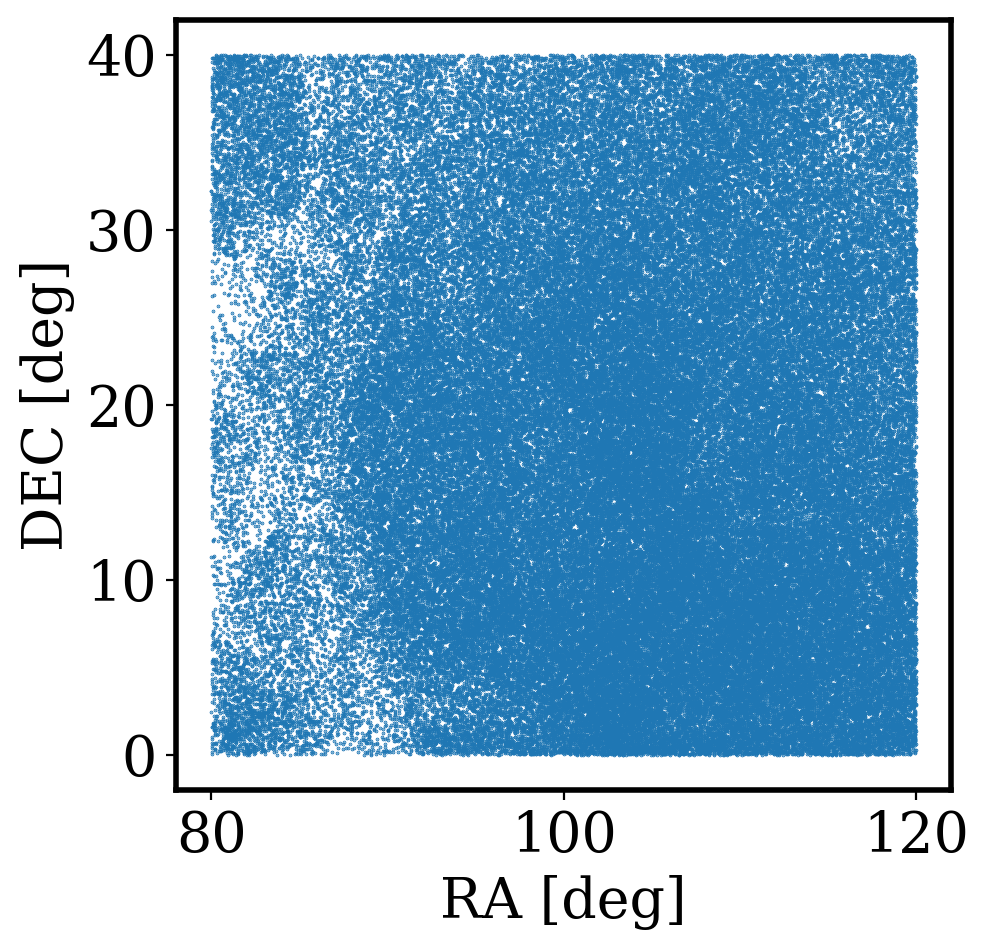

In [11]:
plt.figure(figsize=(5, 5))
plt.scatter(samples_df['RA_ICRS'], samples_df['DE_ICRS'], s=0.1)
plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")

## Select the M-dwarfs

We are interested in finding variability in the M-dwarf type of stars. They are typically in main sequence stage because they burn their hydrogen slowly, and they tend to be very active. Let's filter the objects according to the Spectral Type (`SpType`). The identifier for M-dwarfs is `M`.

In [12]:
samples_df = samples_df[samples_df['SpType'].str.contains('M')]
samples_df = samples_df.drop(columns=['SpType'], axis=1) # this column is no longer needed
print (f"Number of M-type stars: {len(samples_df)}")

Number of M-type stars: 1304


In [13]:
# Have a look at two of them
samples_df.head(2)

,recno,Source,Teff-P,logg-P,[M/H]-P,AG-P,E(BP-RP)-P,[alphe/Fe]-S,Teff-S,logg-S,...,evol-F,Rad-FS,Lum-FS,Mass-FS,Age-FS,evol-FS,RA_ICRS,DE_ICRS,_RA_icrs,_DE_icrs
96,1302564,3414418568469105024,3537.0732,4.8277,-0.4692,1.0736,0.6528,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,80.069883,21.728261,80.069883,21.728261
97,404378,184080241020594432,3480.0610,4.9449,-0.4401,0.5360,0.3295,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,<NA>,80.070542,36.902685,80.070542,36.902685


Text(0, 0.5, 'DEC [deg]')

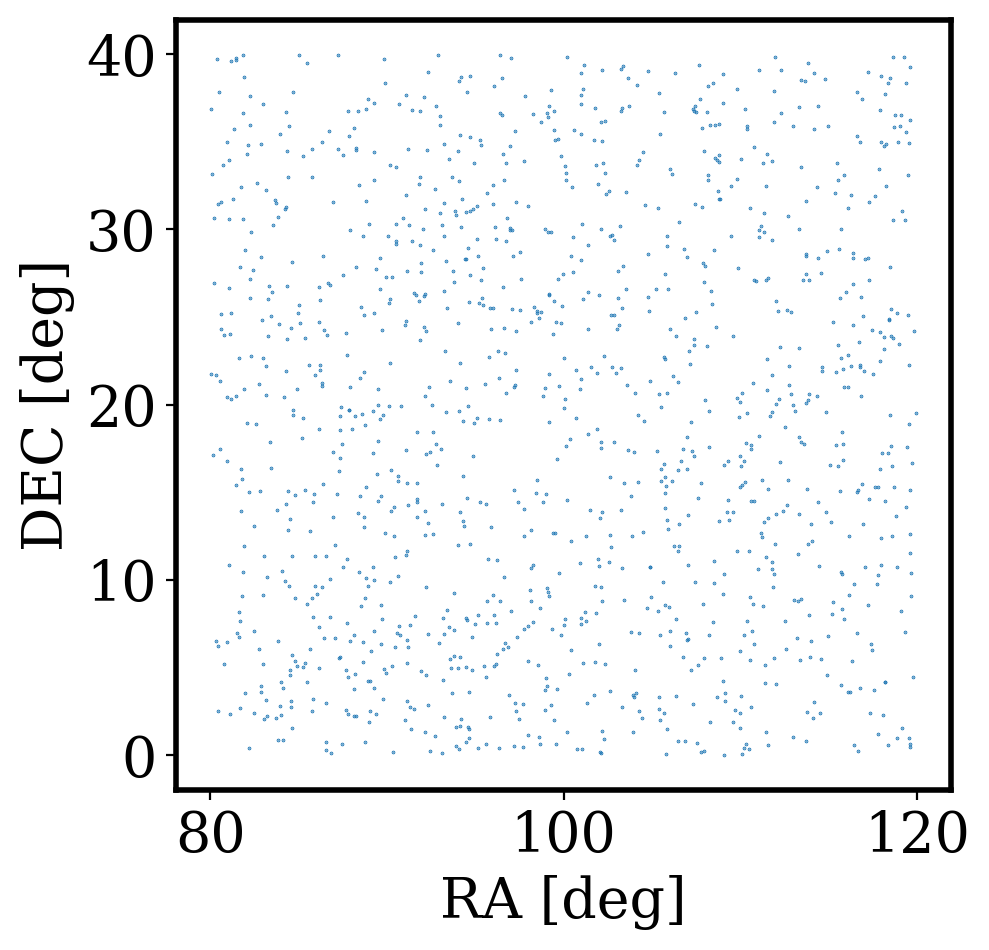

In [14]:
plt.figure(figsize=(5, 5))
plt.scatter(samples_df['RA_ICRS'], samples_df['DE_ICRS'], s=0.1)
plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")

The original table contains a lot of columns. We will select only a handful of them to reduce the object table size. When working with LSDB selecting the minimum viable subset of columns is essential! We do not want to send tasks to our workers with data than we do not need for science our use case.

In [15]:
samples_df.columns.tolist()

['recno',
 'Source',
 'Teff-P',
 'logg-P',
 '[M/H]-P',
 'AG-P',
 'E(BP-RP)-P',
 '[alphe/Fe]-S',
 'Teff-S',
 'logg-S',
 '[M/H]-S',
 'Rad-F',
 'Lum-F',
 'Mass-F',
 'Age-F',
 'evol-F',
 'Rad-FS',
 'Lum-FS',
 'Mass-FS',
 'Age-FS',
 'evol-FS',
 'RA_ICRS',
 'DE_ICRS',
 '_RA_icrs',
 '_DE_icrs']

In [16]:
samples_df = samples_df[['Teff-P', 'RA_ICRS', 'DE_ICRS', 'logg-P', 'Lum-F']]
samples_df.head(1)

,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F
96,3537.0732,80.069883,21.728261,4.8277,0.018851


With temperature and luminosity we are able to generate an HR diagram. We can see how there is a strong correlation between these two variables. Generally the hotter the M-dwarf, the more luminous it is.

Text(0, 0.5, '$\\log L/L_{\\odot}$')

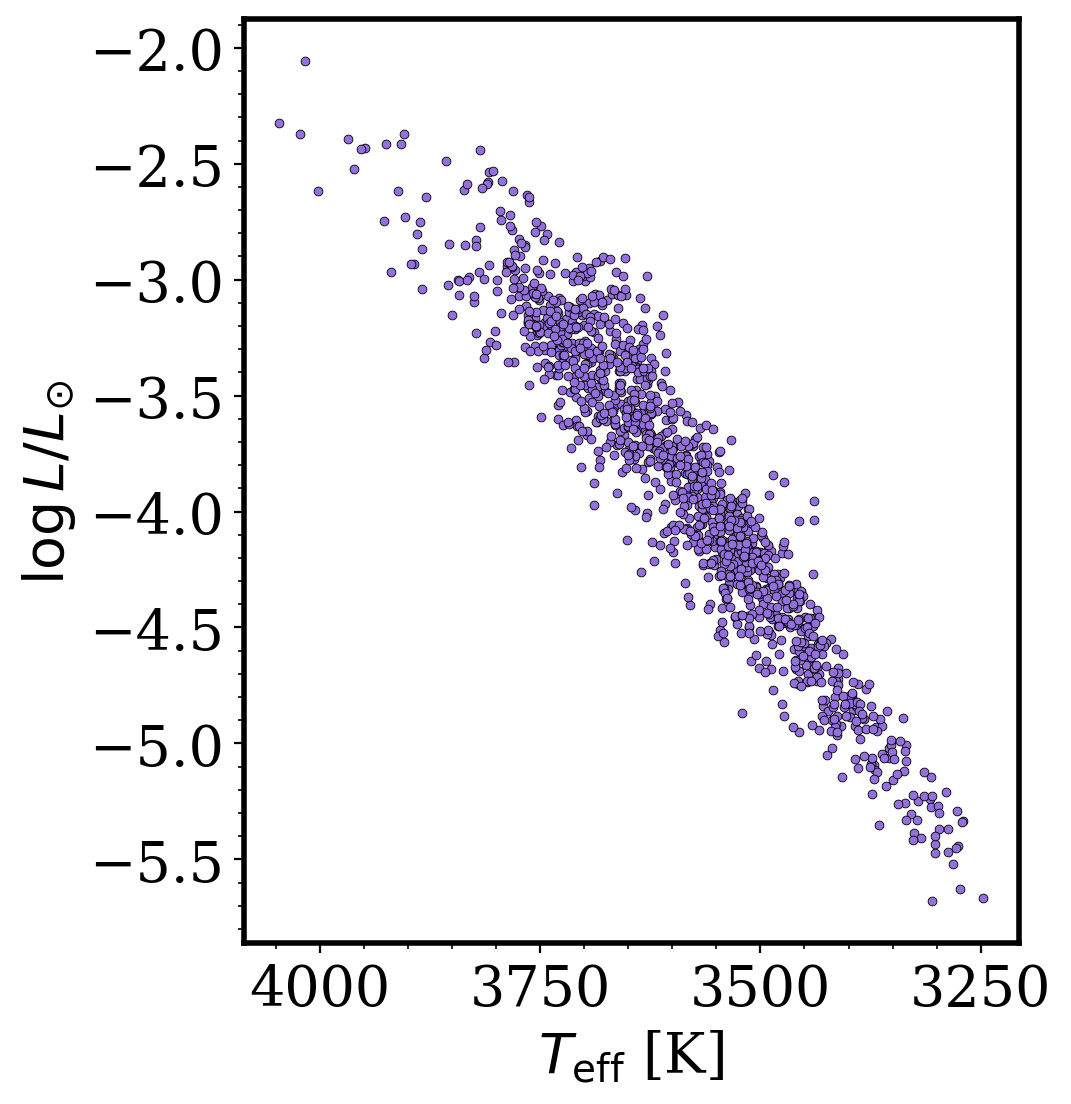

In [17]:
plt.figure(figsize=(5, 6))
plt.scatter((samples_df['Teff-P']), np.log(samples_df['Lum-F']), s=10, color='mediumpurple', edgecolor='k', lw=0.3)
plt.xlim(plt.xlim()[::-1])
plt.minorticks_on()
plt.xlabel(r'$T_{\rm eff}$ [K]')
plt.ylabel(r'$\log L/L_{\odot}$')

## Create a catalog from a table of samples

So far we downloaded samples from the Gaia DR3 Golden Table, hosted on Vizier, and applied filtering in order to obtain the set of all M-type stars. Before we can perform more complex operations with LSDB, we'll need to convert the samples data into a catalog. 

For small datasets of up to 1 million rows we will use `lsdb.from_dataframe`. For larger catalogs we recommend you have a look at [`hipscat-import`](https://github.com/astronomy-commons/hipscat-import), another Python package of our ecosystem which provides a highly-customizable pipeline for advanced use cases.

In [18]:
%%time
samples_cat = lsdb.from_dataframe(
    samples_df,
    catalog_name="golden",
    catalog_type="object",
    ra_column="RA_ICRS", 
    dec_column="DE_ICRS",
)
samples_cat

CPU times: user 5.42 s, sys: 502 ms, total: 5.92 s
Wall time: 5.77 s


,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F,Norder,Dir,Npix
npartitions=3,,,,,,,,
0,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
1152921504606846976,...,...,...,...,...,...,...,...
5764607523034234880,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


In [19]:
samples_cat.head(1)

,Teff-P,RA_ICRS,DE_ICRS,logg-P,Lum-F,Norder,Dir,Npix
_hipscat_index,,,,,,,,
368160526343077888,3480.061,80.070542,36.902685,4.9449,0.014007,0,0,0


Our catalog points are all contained in this region of the sky.

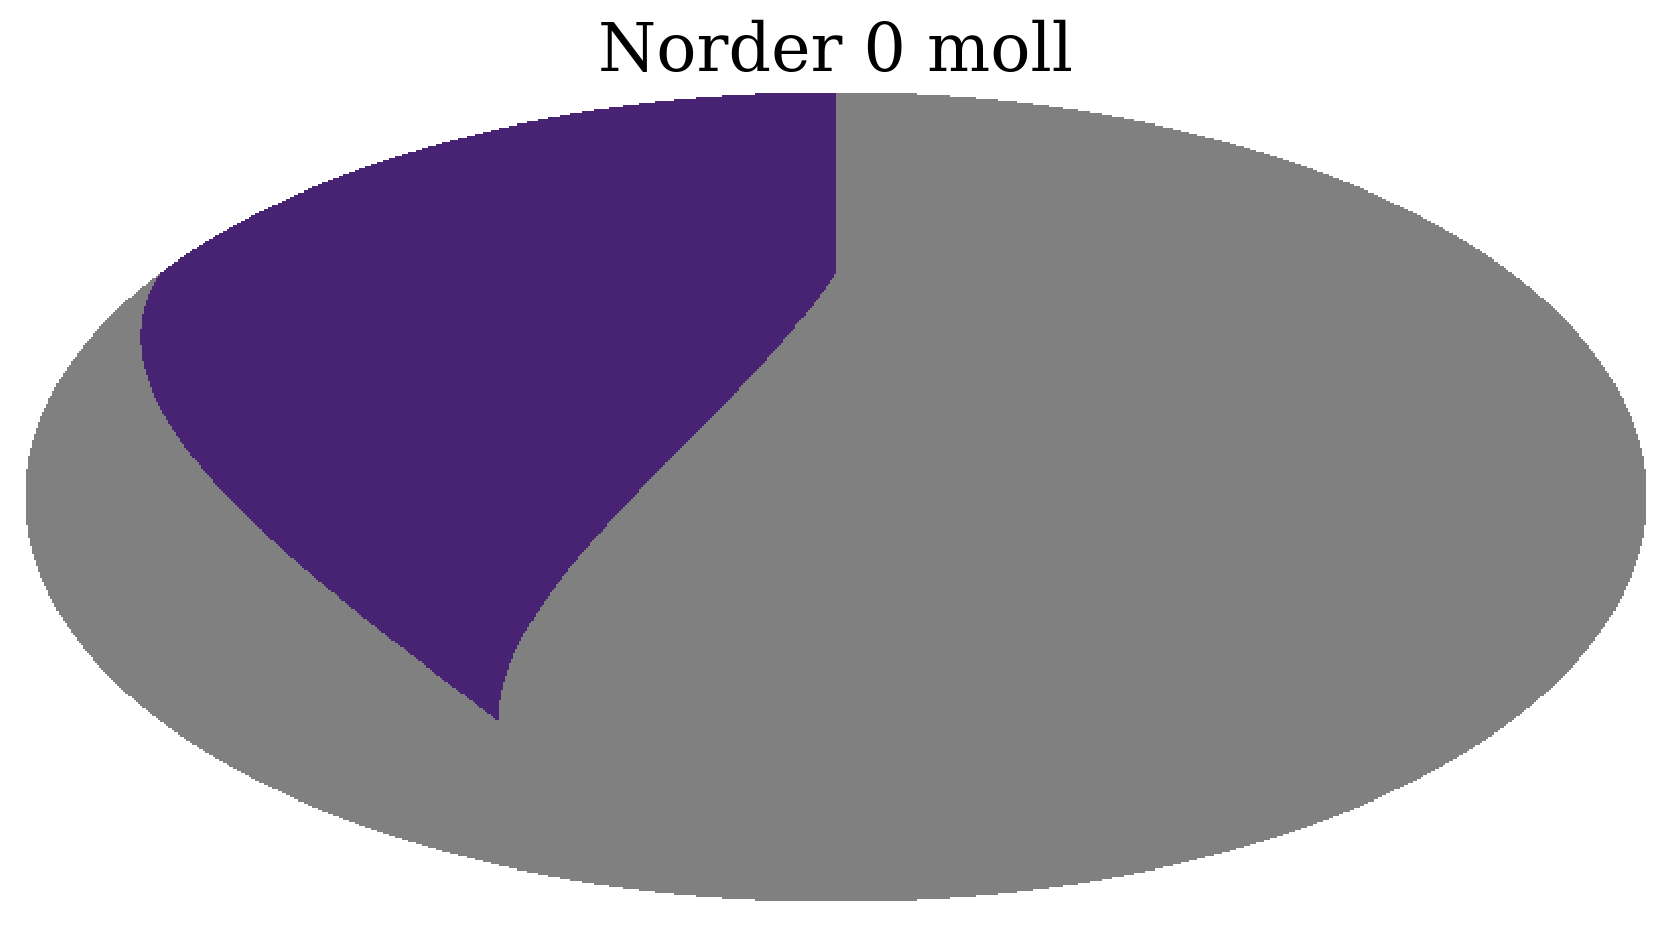

In [20]:
samples_cat.plot_pixels()

## Crossmatch

Let's crossmatch our samples catalog to the ZTF object table. Remember that by default we are obtaining single matches within 1 arcsecond radius of each sample.

In [21]:
xmatch_golden_ztf_object = samples_cat.crossmatch(ztf)

In [22]:
# Have a look at one of our matches!
xmatch_golden_ztf_object.head(1)

,Teff-P_golden,RA_ICRS_golden,DE_ICRS_golden,logg-P_golden,Lum-F_golden,Norder_golden,Dir_golden,Npix_golden,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,_dist_arcsec
_hipscat_index,,,,,,,,,,,,
1777352498969837568,3595.5603,102.095831,30.048567,4.8826,0.021545,0,0,1,102.095798,30.048563,144051020958648924,0.102797


Joining our samples with the respective light curves from ZTF - similar to what we did in notebook 2.

In [23]:
%%time
_sources = xmatch_golden_ztf_object.join_nested(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid", nested_column_name="sources")
_sources = _sources._ddf # remove once have added LSDB wrappers for nested_dask
_sources

CPU times: user 125 ms, sys: 3.98 ms, total: 129 ms
Wall time: 121 ms


/opt/conda/envs/mwgaia-school/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:334: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,Teff-P_golden,RA_ICRS_golden,DE_ICRS_golden,logg-P_golden,Lum-F_golden,Norder_golden,Dir_golden,Npix_golden,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,_dist_arcsec,sources
npartitions=83,,,,,,,,,,,,,
1774418253183975424,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], mjd: [double], mag: [float], magerr: [float], band: [string], catflags: [int16]>"
1774699728160686080,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6871930081413955584,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...


In [24]:
# Observe a light curve from our result
object_id = 6759861235694436352
lc_object = _sources.loc[object_id].query("sources.band == 'r'")
lc = lc_object.sources.compute().iloc[0]
lc

,ra,dec,mjd,mag,magerr,band,catflags
0,101.37241,24.326344,59625.17066,16.362036,0.013841,r,0
1,101.37241,24.326344,59800.49771,16.375069,0.013885,r,0
2,101.37241,24.326344,59801.49749,16.364861,0.013850,r,0
3,101.37241,24.326344,58819.46465,16.364126,0.013848,r,-32768
4,101.37241,24.326344,59801.49271,16.346504,0.013788,r,0
...,...,...,...,...,...,...,...
841,101.37241,24.326344,58791.40682,16.364161,0.013848,r,0
842,101.37241,24.326344,58791.40637,16.374510,0.013883,r,0
843,101.37241,24.326344,58791.40592,16.378267,0.013896,r,0
844,101.37241,24.326344,58791.40547,16.348888,0.013796,r,0


We are now able to plot this ZTF-r band light curve.

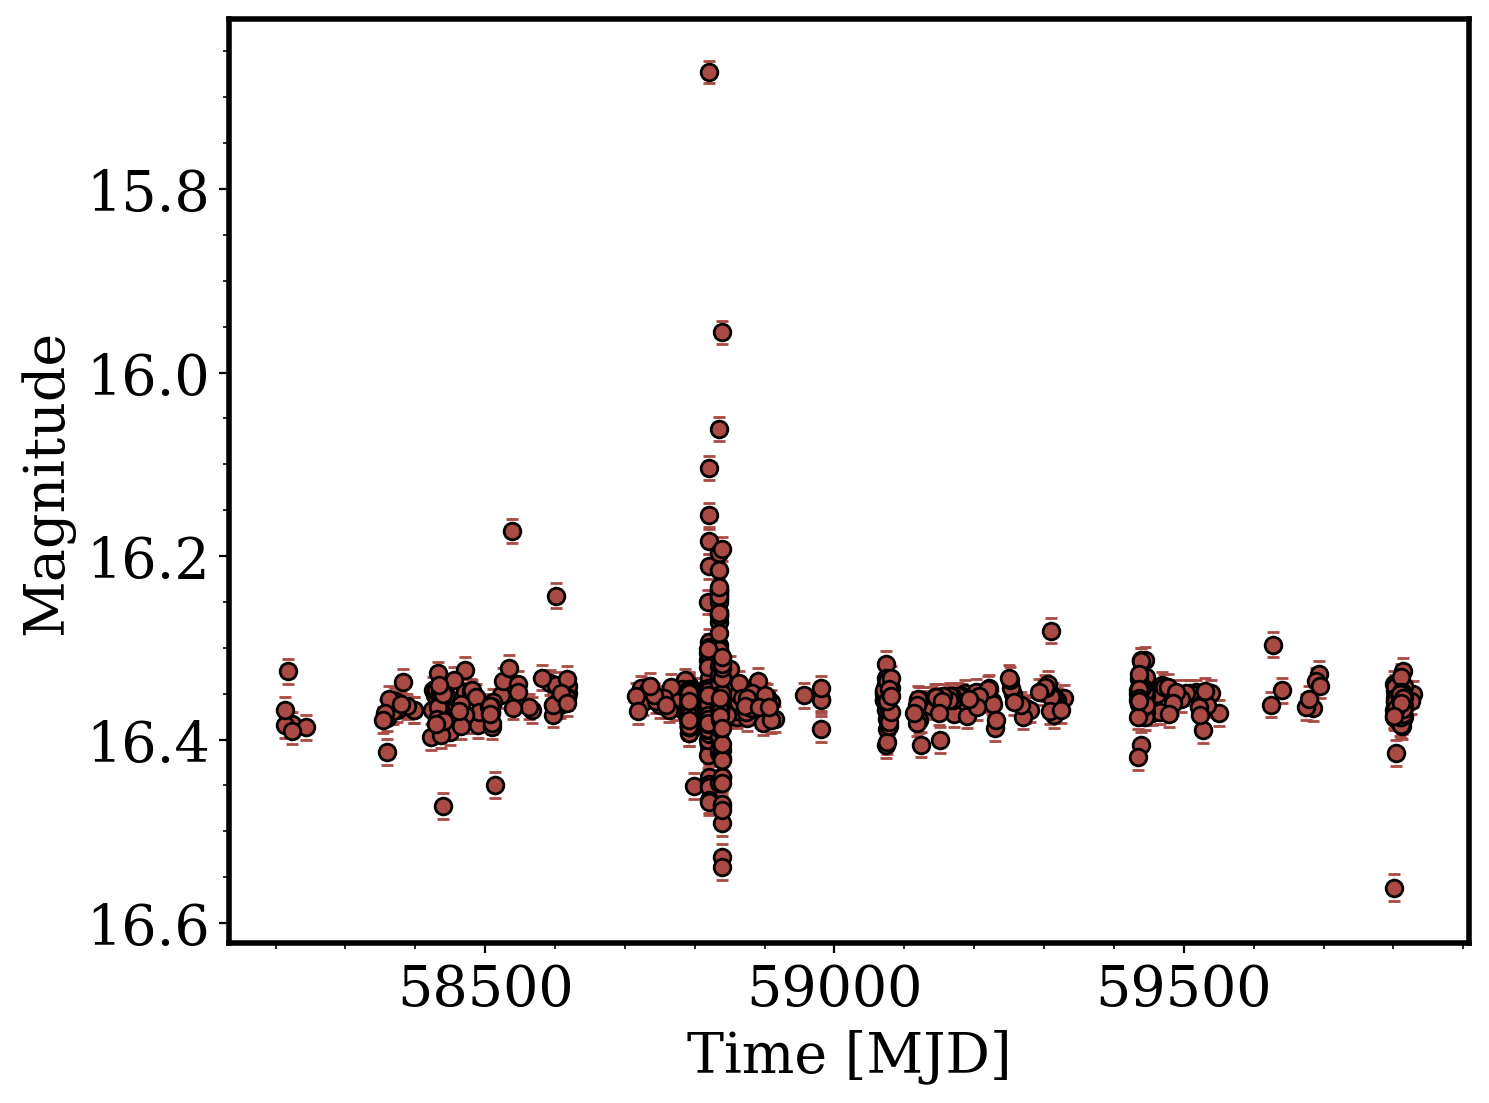

In [25]:
plt.figure(figsize=(8, 6))
plt.errorbar(
    lc["mjd"],
    lc["mag"],
    yerr=lc["magerr"], 
    color='#AA4A44', fmt='o', capsize=2, mec='k', lw=0.1)
plt.ylabel('Magnitude')
plt.xlabel('Time [MJD]')
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()

## Extract features from light curves

We will now compute the following set of features for each light curve. This time we will use an external package called [`cesium`](https://github.com/cesium-ml/cesium).

In [26]:
features_to_use = [
    'amplitude',
    'percent_beyond_1_std',
    'maximum',
    'median',
    'median_absolute_deviation',
    'percent_close_to_median',
    'minimum',
    'skew',
    'std',
    'weighted_average', 
    "flux_percentile_ratio_mid20", 
    "flux_percentile_ratio_mid35",
    "flux_percentile_ratio_mid50",
    "flux_percentile_ratio_mid65",
    "flux_percentile_ratio_mid80",
    "stetson_j",
    "stetson_k"
]

In [27]:
def compute_features(time, mag, magerr, flag, band, custom_cols=features_to_use):
    """ Compute features using Cesium for a given light curve.

    Parameters
    ----------
    time : array-like
        Time of observation
    mag : array-like
        Magnitude of the object
    magerr : array-like
        Error in the magnitude
    flag : array-like
        catflag for the object

    Returns
    -------
    fset_cesium : pandas.Series
        A pandas series containing the computed features
    """
    
    # Quality flags
    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)

    # Removed flagged data points
    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]

    if len(time_) > 0: 
        fset_cesium = featurize.featurize_time_series(
        times=time_,
        values=mag_,
        errors=magerr_,
        features_to_use=custom_cols)
    else:
        fset_cesium = pd.Series(list(np.zeros(len(features_to_use))), index=custom_cols) 
    
    return pd.Series(fset_cesium.values[0], index=custom_cols) 

We can now apply the feature calculator function `calc_features` to each light curve. Often, you'll need the specify the "meta" of the output, i.e. the expected type for your result, as a consequence of these operations being lazy. In this case, we specify that every column will be of floating type.

In [28]:
calc_ = _sources.reduce(
    compute_features,
    'sources.mjd', 
    'sources.mag', 
    'sources.magerr', 
    'sources.catflags',
    'sources.band',
    meta={name: float for name in features_to_use}
)

In [29]:
%%time
# takes around 7 minutes
new_table = calc_.compute()

CPU times: user 19.6 s, sys: 3.77 s, total: 23.3 s
Wall time: 7min 16s


In [30]:
new_table

,amplitude,percent_beyond_1_std,maximum,median,median_absolute_deviation,percent_close_to_median,minimum,skew,std,weighted_average,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,stetson_j,stetson_k
_hipscat_index,,,,,,,,,,,,,,,,,
1776922061407518720,0.076140,0.328118,15.212175,15.123099,0.012123,0.617828,15.059896,0.119107,0.018150,15.123840,0.149169,0.269150,0.411376,0.568593,0.782407,-0.982967,0.989750
1776909467871346688,0.082614,0.329469,14.254035,14.142938,0.010978,0.677778,14.088806,0.175416,0.017048,14.143996,0.140042,0.254950,0.389828,0.560151,0.787622,-0.984686,0.981848
1776790564075732992,0.075825,0.277583,16.371937,16.293283,0.010355,0.661279,16.220287,0.137026,0.017321,16.293788,0.136344,0.249718,0.366173,0.529972,0.758177,-0.984483,0.961196
1777151053796474880,0.113545,0.259211,17.717175,17.592513,0.018099,0.603947,17.490084,0.268701,0.031560,17.591448,0.134344,0.245289,0.364547,0.507745,0.734164,-0.933488,0.936645
1777352498969837568,0.081447,0.319426,16.826321,16.746338,0.015026,0.537158,16.663427,-0.046182,0.022197,16.745359,0.146181,0.274295,0.409257,0.562733,0.767244,-0.974165,0.993333
1873543153118609408,0.146191,0.236531,15.275710,15.115598,0.013895,0.847569,14.983329,-0.500855,0.024812,15.114589,0.129117,0.254210,0.378607,0.523041,0.711129,-0.961500,0.897833
6759861235694436352,0.052757,0.274924,16.418705,16.361895,0.008821,0.589124,16.313190,0.048448,0.014154,16.361353,0.146970,0.269720,0.397893,0.551996,0.743753,-0.989740,0.962813
6763056230786138112,0.088201,0.273621,16.215702,16.119698,0.010773,0.727135,16.039301,0.050355,0.017467,16.119739,0.144471,0.260029,0.378466,0.523540,0.733181,-0.984028,0.960818
6763105036554731520,0.047082,0.317460,14.725718,14.667343,0.008973,0.534392,14.631554,0.476860,0.012829,14.668046,0.167918,0.290467,0.446868,0.616877,0.765362,-0.991552,0.980090


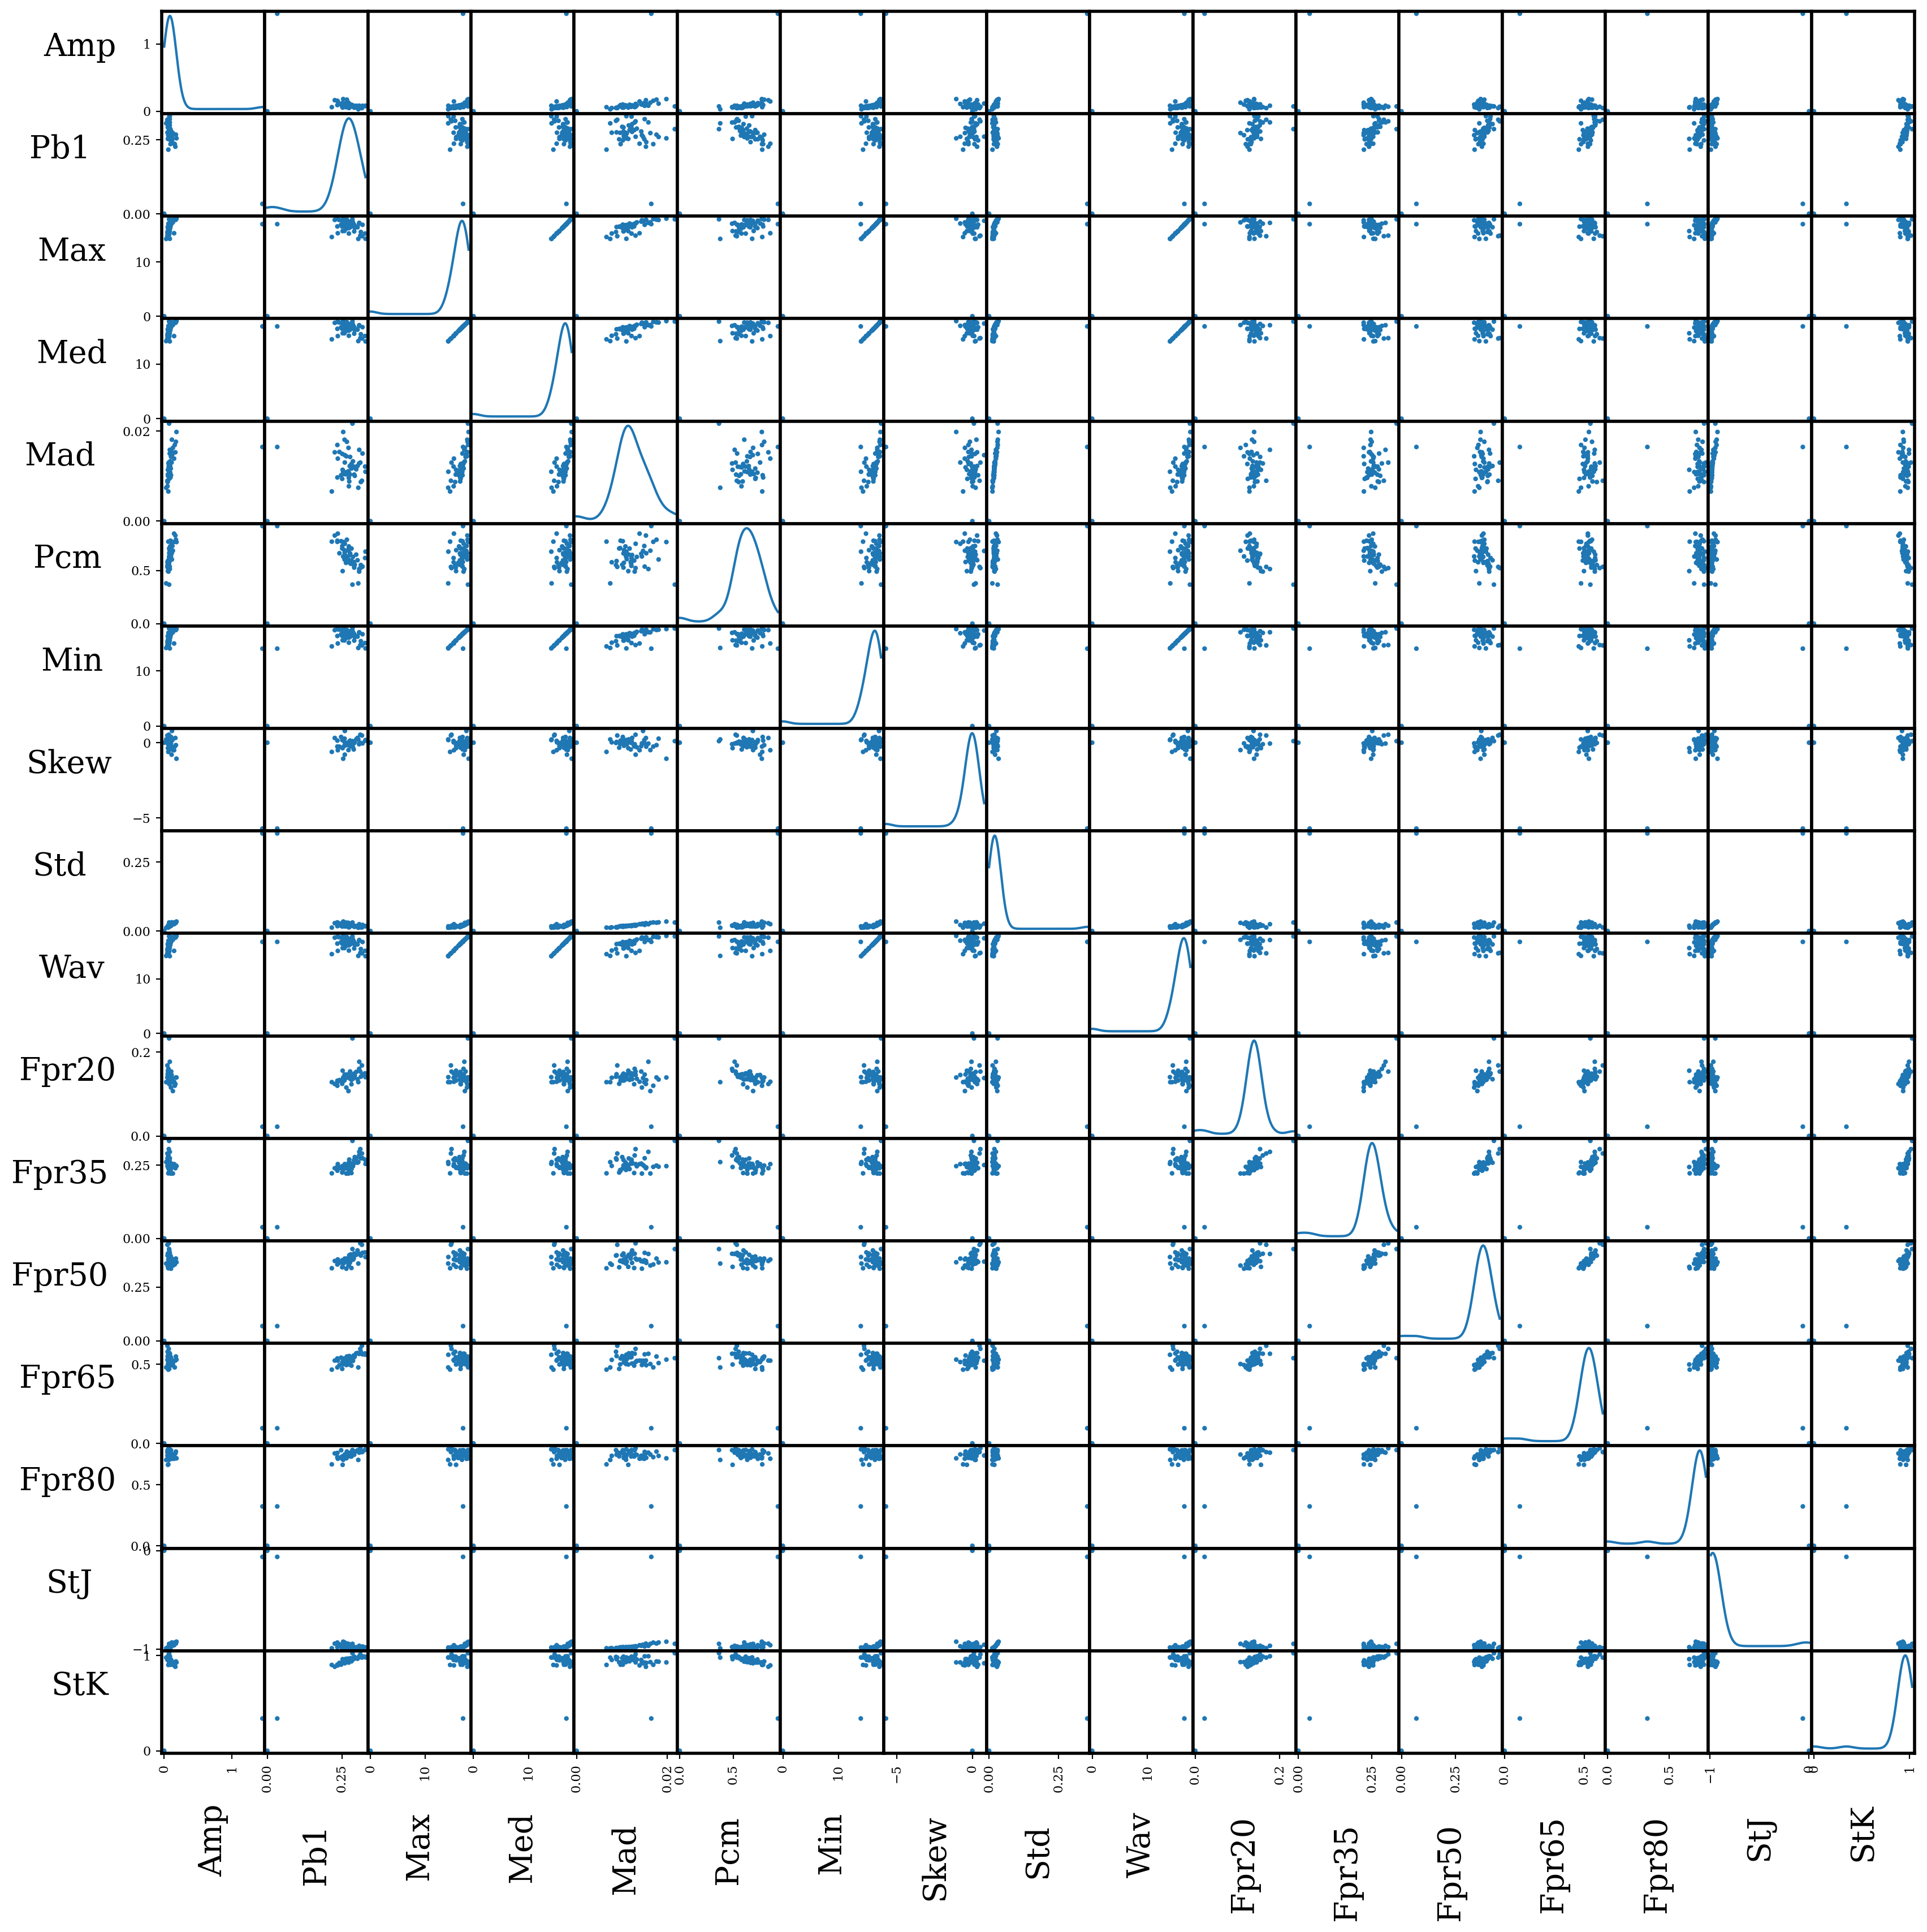

In [31]:
# Short labels for the features
labels_short = [
    'Amp', 'Pb1', 'Max', 'Med', 'Mad', 'Pcm', 'Min', 'Skew', 'Std',
    'Wav', 'Fpr20', 'Fpr35', 'Fpr50', 'Fpr65', 'Fpr80', 'StJ', 'StK'
]

# Rename the columns
new_table.columns = labels_short

# Create the scatter matrix
scatter_matrix = pd.plotting.scatter_matrix(new_table, alpha=1, figsize=(20, 20), diagonal='kde')

# Customize the labels
for i, ax in enumerate(scatter_matrix[:, 0]):
    ax.set_ylabel(labels_short[i], rotation=0, labelpad=40)
for j, ax in enumerate(scatter_matrix[-1, :]):
    ax.set_xlabel(labels_short[j], rotation=90, labelpad=20)

This matrix is a starting point to find interesting correlations for subgroups of features. We can build upon this workflow and apply clustering algorithms or try to isolate outliers to perform anomaly detection.

In [32]:
# Release allocated resources!
client.close()